In [48]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.utils.data import Dataset
from unet_model import UNet

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [28]:
# Root directory for dataset
dataroot = "dataset/"

# Batch size during training
batch_size = 1

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 256

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [3]:
class MyDataset(Dataset):

    def __init__(self, X_path="dataset/x_train.npy", y_path="dataset/y_train.npy", transform_flag=False):
        self.X = np.load(X_path).transpose(0, 3, 1, 2)
        self.y = np.load(y_path)
        self.transform_flag = transform_flag
    
    def __len__(self):
        return self.X.shape[0]
    
    def transform(self, image, mask):
        # Random crop
        image = torch.tensor(image)
        mask = torch.tensor(mask)
        i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(256,256))
        image = transforms.functional_tensor.crop(image, i, j, h, w)
        mask = transforms.functional_tensor.crop(mask, i, j, h, w)

        # Random horizontal flipping
        if np.random.rand() > 0.5:
            image = transforms.functional_tensor.hflip(image)
            mask = transforms.functional_tensor.hflip(mask)
        
        # Random brightness
        if np.random.rand() > 0.1:
            image = transforms.functional_tensor.adjust_brightness(image, np.random.rand() + 0.5)
        
        # Random Contrast
        if np.random.rand() > 0.1:
            image = transforms.functional_tensor.adjust_contrast(image, np.random.rand() + 0.5)
        
        # Random Gamma
        if np.random.rand() > 0.1:
            image = transforms.functional_tensor.adjust_gamma(image, np.random.rand() + 0.5)
            
        # Random Hue
        if np.random.rand() > 0.1:
            image = transforms.functional_tensor.adjust_hue(image, np.random.rand() - 0.5)
            
        # Random Saturation
        if np.random.rand() > 0.1:
            image = transforms.functional_tensor.adjust_saturation(image, np.random.rand() + 0.5)
            
        return image, mask

    def __getitem__(self, idx):
        if self.transform_flag:
            return self.transform(self.X[idx], np.expand_dims(self.y[idx], 0))
        else:
            return self.X[idx], np.expand_dims(self.y[idx], 0)

In [10]:
train_dataset = MyDataset("dataset/x_train.npy", "dataset/y_train.npy", transform_flag=True)
val_dataset = MyDataset("dataset/x_val.npy", "dataset/y_val.npy", transform_flag=False)
test_dataset = MyDataset("dataset/x_test.npy", "dataset/y_test.npy", transform_flag=False)

# Create the dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True)

# Decide which device we want to run on
device = 'cuda'

# # Plot some training images
# real_batch = next(iter(train_loader))
# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

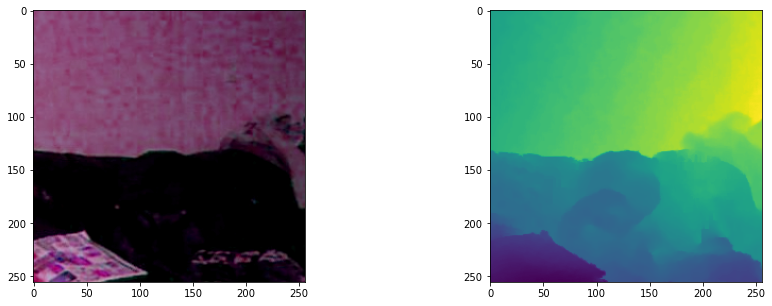

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for batch_idx, (data, target) in enumerate((train_loader)):
    axes[0].imshow(np.transpose(data[0], (1,2,0)))
    axes[1].imshow(np.transpose(target[0], (1,2,0)))
    #print(target.shape)
    break

In [27]:
modelG = UNet(3, 1, bilinear=False)

#model.load_state_dict(torch.load("models/Unet_l1/model_100.pth"))
modelG = modelG.to(device)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)

print(modelG)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [45]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Flatten(),
            nn.Linear(13*13, 36),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(36, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [81]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(nc, ndf , 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf*2 , 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(ndf*2)
        self.conv3 = nn.Conv2d(ndf *2, ndf * 4 , 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ndf*4)
        self.conv4 = nn.Conv2d(ndf *4, ndf * 8 , 4, 2, 1, bias=False)
        self.conv5 = nn.Conv2d(ndf *8, 1, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf*8)
        self.fc1 = nn.Linear(64, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.bn1(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn2(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.conv4(x)), 0.2)
        x = F.leaky_relu(self.conv5(x), 0.2)
        #print(x.shape)
        x = torch.flatten(x, 0)
        #print(x.shape)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.sigmoid(x)
        return x



In [82]:
modelD = Discriminator().to(device)
print(modelD)

Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=64, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)


In [86]:
optimizerG = torch.optim.Adam(modelG.parameters(), lr=0.01, weight_decay = 1e-3)
optimizerD = torch.optim.Adam(modelD.parameters(), lr=0.01, weight_decay = 1e-3)

criterionD = nn.BCELoss()

(data, target) = next(iter(train_loader))
fixed_data = data.to(device)

real_label = 1.
fake_label = 0.

In [87]:
def logMSE(pred, groundtruth, lamda = 0.5):
    #as implemented in https://arxiv.org/pdf/1406.2283.pdf
    log_pred = torch.log(pred)
    log_gt = torch.log(groundtruth)
    d = log_pred - log_gt
    n = torch.numel(pred)
    first_term = torch.sum(d**2)/n
    second_term = torch.sum(d)**2 / n**2
    
    return first_term - lamda * second_term

In [90]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 20

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data, target) in enumerate((train_loader)):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        modelD.zero_grad()
        # Format batch
        target = target.to(device)
        #print(target.shape)
        b_size = target.size(0)
        
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = modelD(target)
        #print(output.shape)
        # Calculate loss on all-real batch
        errD_real = criterionD(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        # noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        data= data.to(device)
        fake = modelG(data.float())
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = modelD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterionD(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        modelG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = modelD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterionD(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = modelG(fixed_data.float()).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/20][0/1014]	Loss_D: 1.3158	Loss_G: 0.8895	D(x): 0.4576	D(G(z)): 0.4138 / 0.4109
[0/20][50/1014]	Loss_D: 1.2941	Loss_G: 0.8430	D(x): 0.4838	D(G(z)): 0.4334 / 0.4304
[0/20][100/1014]	Loss_D: 1.3243	Loss_G: 0.6571	D(x): 0.5347	D(G(z)): 0.5025 / 0.5183
[0/20][150/1014]	Loss_D: 1.3935	Loss_G: 0.7943	D(x): 0.4557	D(G(z)): 0.4553 / 0.4519
[0/20][200/1014]	Loss_D: 1.3970	Loss_G: 0.7968	D(x): 0.4531	D(G(z)): 0.4541 / 0.4508
[0/20][250/1014]	Loss_D: 1.4416	Loss_G: 0.6438	D(x): 0.5331	D(G(z)): 0.5563 / 0.5253
[0/20][300/1014]	Loss_D: 1.4027	Loss_G: 0.7289	D(x): 0.4770	D(G(z)): 0.4844 / 0.4824
[0/20][350/1014]	Loss_D: 0.8323	Loss_G: 0.7693	D(x): 0.8099	D(G(z)): 0.4628 / 0.4633
[0/20][400/1014]	Loss_D: 1.9076	Loss_G: 1.1916	D(x): 0.1978	D(G(z)): 0.2494 / 0.3037
[0/20][450/1014]	Loss_D: 1.8274	Loss_G: 1.4723	D(x): 0.2144	D(G(z)): 0.2498 / 0.2294
[0/20][500/1014]	Loss_D: 0.7242	Loss_G: 0.7985	D(x): 0.9098	D(G(z)): 0.4672 / 0.4500
[0/20][550/1014]	Loss_D: 1.8781	Loss_G: 0.

KeyboardInterrupt: 

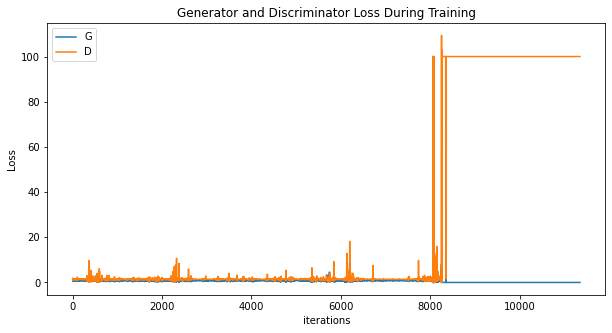

In [91]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()